In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pickle

In [3]:
filename = '/content/drive/My Drive/data.pkl'         ###load the whole data to create tokenizer
data = pickle.load(open(filename,'rb'))
data.shape

(70000, 2)

In [4]:
for i in range(len(data)):                    ###add start and end tokens in german to denote start and end of sequence
    data[i,1]='start '+ data[i,1] + ' end'

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [6]:
def create_tokens(lines):
    tokens = Tokenizer()        ###function to create tokens
    tokens.fit_on_texts(lines)
    return tokens

In [7]:
english_tokenizer = create_tokens(data[:,0])       ###fit a tokenizer
german_tokenizer = create_tokens(data[:,1])

In [8]:
def encode_sentences(tokens,length,lines):   ###function to pad the data to maximum phrase length
    X=tokens.texts_to_sequences(lines)
    X=pad_sequences(X,length,padding='post')
    return X    

In [9]:
def max_len_sen(data):                       ###function to calculate maximum length
    return max(len(line.split()) for line in data)

In [10]:
eng_vocab = len(english_tokenizer.word_index)+1
german_vocab = len(german_tokenizer.word_index)+1
print('Vocabulary size of english words is {}'.format(eng_vocab))
print('Vocabulary size of german words is {}'.format(german_vocab))

Vocabulary size of english words is 11417
Vocabulary size of german words is 21679


In [11]:
eng_len = max_len_sen(data[:,0])
ger_len = max_len_sen(data[:,1])
print ('Maximum length in English is {}'.format(eng_len))
print ('Maximum length in German is {}'.format(ger_len))

Maximum length in English is 44
Maximum length in German is 47


In [12]:
filename1 = '/content/drive/My Drive/eng-ger_train.pkl'                   ###load training, validation and test data
filename2 = '/content/drive/My Drive/eng-ger_val.pkl' 
filename3 = '/content/drive/My Drive/eng-ger_test.pkl'       
train = pickle.load(open(filename1,'rb'))
val = pickle.load(open(filename2,'rb'))
test = pickle.load(open(filename3,'rb'))
train.shape, val.shape, test.shape

((50000, 2), (10000, 2), (10000, 2))

In [13]:
for i in range(len(train)):                    ###add start and end tokens in german to denote start and end of sequence
    train[i,1]='start '+ train[i,1] + ' end'
for i in range(len(val)):                    ##convert to lowercase
    val[i,1]='start '+ val[i,1] + ' end'
for i in range(len(test)):                    ##convert to lowercase
    test[i,1]='start '+ test[i,1] + ' end'


In [14]:
X_train = encode_sentences(english_tokenizer,ger_len,train[:,0])          ###pad the data to maximum length
X_val = encode_sentences(english_tokenizer,ger_len,val[:,0])              ### X ---> English, Y ---> German
X_test= encode_sentences(english_tokenizer,ger_len,test[:,0])
Y_train = encode_sentences(german_tokenizer,ger_len,train[:,1])
Y_val = encode_sentences(german_tokenizer,ger_len,val[:,1])
Y_test = encode_sentences(german_tokenizer,ger_len,test[:,1])

In [15]:
print(X_train.shape)
print(X_val.shape)   ###check for dimensions
print(X_test.shape)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(50000, 47)
(10000, 47)
(10000, 47)
(50000, 47)
(10000, 47)
(10000, 47)


In [16]:
from tensorflow.keras.models import Sequential, load_model,Model
from tensorflow.keras.layers import Embedding, Reshape, Lambda, Activation
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, RepeatVector, TimeDistributed, Concatenate, GRU
from tensorflow.keras.layers import Dropout,Input,Dot
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf
from tensorflow.keras.backend import permute_dimensions, sqrt, constant

In [17]:
class Encoder(tf.keras.Model):
      def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

      def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [18]:
class BahdanauAttention(tf.keras.layers.Layer):
      def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [19]:
class Decoder(tf.keras.Model):
      def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.gru = GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
        output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [20]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

# PARAMETERS OF MODEL

In [21]:
BATCH_SIZE = 256
embedding_dim = 512
enc_units = 512
dec_units = 512

In [24]:
encoder = Encoder(eng_vocab, embedding_dim,enc_units,BATCH_SIZE)
decoder = Decoder(german_vocab,embedding_dim,dec_units,BATCH_SIZE)

In [25]:
dataset= tf.data.Dataset.from_tensor_slices((X_train,Y_train)).shuffle(50000)
dataset = dataset.batch(BATCH_SIZE)

In [26]:
import os
checkpoint_dir = '/content/drive/My Drive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [27]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([german_tokenizer.word_index['start']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
          predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

          loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
          dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [28]:
EPOCHS = 25
import time
steps_per_epoch = 50000//BATCH_SIZE
plot_loss=[]
for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(50000//BATCH_SIZE)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
          print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        plot_loss.append(total_loss / steps_per_epoch)
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.5774
Epoch 1 Batch 100 Loss 0.9625
Epoch 1 Loss 1.0099
Time taken for 1 epoch 197.50204372406006 sec

Epoch 2 Batch 0 Loss 0.9130
Epoch 2 Batch 100 Loss 0.8916
Epoch 2 Loss 0.8707
Time taken for 1 epoch 161.47234439849854 sec

Epoch 3 Batch 0 Loss 0.8654
Epoch 3 Batch 100 Loss 0.8606
Epoch 3 Loss 0.7872
Time taken for 1 epoch 160.09401655197144 sec

Epoch 4 Batch 0 Loss 0.6836
Epoch 4 Batch 100 Loss 0.7561
Epoch 4 Loss 0.7124
Time taken for 1 epoch 161.44120955467224 sec

Epoch 5 Batch 0 Loss 0.6624
Epoch 5 Batch 100 Loss 0.6462
Epoch 5 Loss 0.6444
Time taken for 1 epoch 160.38975715637207 sec

Epoch 6 Batch 0 Loss 0.6260
Epoch 6 Batch 100 Loss 0.6166
Epoch 6 Loss 0.5818
Time taken for 1 epoch 161.62716484069824 sec

Epoch 7 Batch 0 Loss 0.5415
Epoch 7 Batch 100 Loss 0.5027
Epoch 7 Loss 0.5275
Time taken for 1 epoch 160.1834750175476 sec

Epoch 8 Batch 0 Loss 0.4626
Epoch 8 Batch 100 Loss 0.4739
Epoch 8 Loss 0.4755
Time taken for 1 epoch 161.5344226360321 sec

Ep

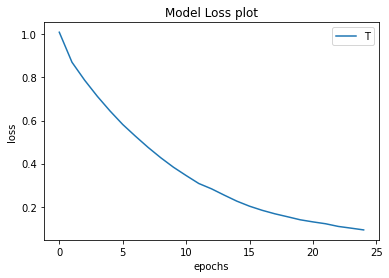

In [31]:
import matplotlib.pyplot as plt        ###Plot loss on training data
plt.plot(plot_loss)                   
plt.title('Model Loss plot')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend('Train')
plt.show()

In [57]:
def evaluate(sentence):
    attention_plot = np.zeros((ger_len, ger_len))


    inputs = [english_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=ger_len, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = 'start '

    hidden = [tf.zeros((1, enc_units))]
      enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([german_tokenizer.word_index['start']], 0)

    for t in range(ger_len):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()  ###greedy decoder 

        result += german_tokenizer.index_word[predicted_id] + ' '

        if german_tokenizer.index_word[predicted_id] == 'end':  ###stop predicting once the model encounter 'end' token
              return result, sentence, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

# PLOT ATTENTION WEIGHTS

In [76]:
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='gist_gray')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [59]:
predicted = []
actual = []
for i in range(len(test)):

    result, sentence, attention_plot = evaluate(test[:,0][i])
    predicted.append(result.split())
    references = [test[:,1][i].split()]
    actual.append(references)
    if i%100==0:
        print('src=[%s],target=[%s],predicted=[%s]'%(test[:,0][i],test[:,1][i],result))

src=[tom spent all afternoon cleaning his room],target=[start tom verbrachte den ganzen nachmittag damit sein zimmer aufzuräumen end],predicted=[start tom verbrachte den ganzen nachmittag über sein zimmer auf end ]
src=[theres a lot of traffic on that street],target=[start auf der straße gibt es viel verkehr end],predicted=[start es gibt viel zu dieser straße end ]
src=[id like to study with you tonight but i cant],target=[start ich würde heute abend gerne mit dir lernen aber ich kann nicht end],predicted=[start ich möchte heute abend gerne mit dir ein bisschen hingehen und ich nicht end ]
src=[where does tom usually eat lunch],target=[start wo isst tom gewöhnlich zu mittag end],predicted=[start wo macht tom gewöhnlich zu mittag end ]
src=[tom won 10000 in the lottery],target=[start tom gewann zehntausend dollar in der lotterie end],predicted=[start tom hat zehntausend dollar im lotto gewonnen end ]
src=[we should help tom],target=[start wir sollten tom helfen end],predicted=[start wir

In [60]:
from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.625683
BLEU-2: 0.472794
BLEU-3: 0.375506
BLEU-4: 0.294959


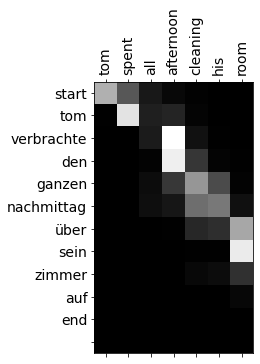

In [77]:
result, sentence, attention_plot = evaluate(test[:,0][0])
attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
plot_attention(attention_plot, sentence.split(' '), result.split(' '))

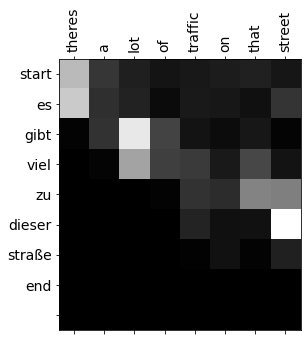

In [78]:
result, sentence, attention_plot = evaluate(test[:,0][100])
attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
plot_attention(attention_plot, sentence.split(' '), result.split(' '))

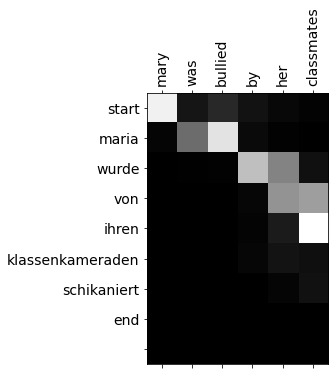

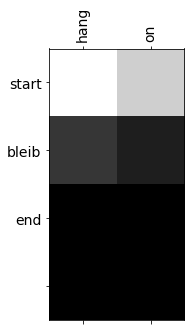

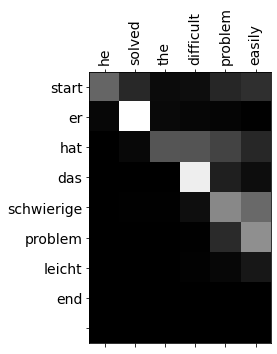

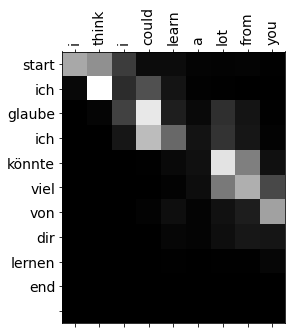

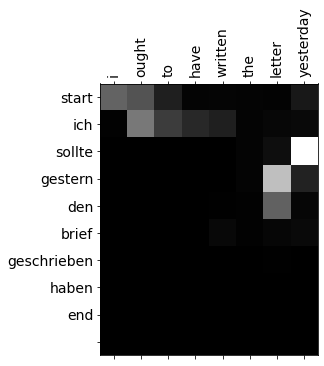

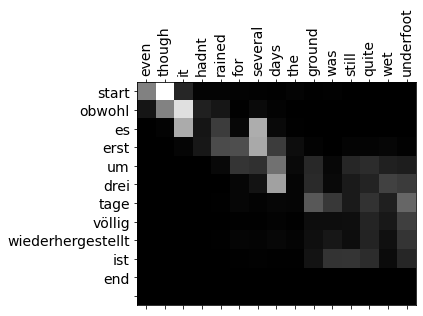

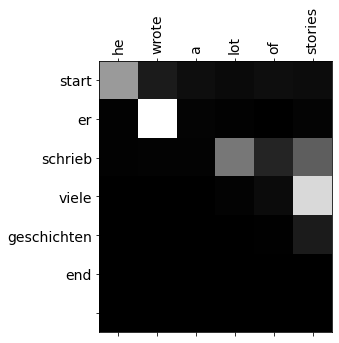

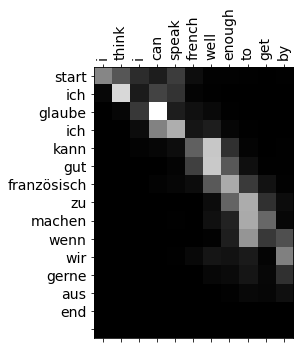

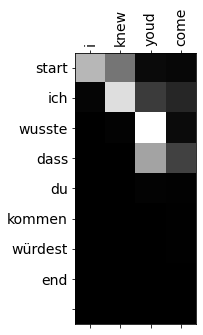

In [87]:
i = [10,25,562, 3305, 2788,9990,4789,2205,7654]
for j in i:
    result, sentence, attention_plot = evaluate(test[:,0][j])
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))